In [1]:
import random
from contextlib import contextmanager

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots

#import seaborn as sns

_ = random
_ = matplotlib
#_ = sns
_ = scienceplots

In [2]:
%matplotlib inline

In [3]:
#plt.style.use(["science"])

#plt.rcParams["axes.titlesize"] = 14
#plt.rcParams["axes.labelsize"] = 12
#plt.rcParams["xtick.labelsize"] = 12
#plt.rcParams["ytick.labelsize"] = 12
#plt.rcParams["legend.fontsize"] = 12

BAR_TEXT_FONTSIZE = 7

In [4]:
@contextmanager
def save_plot(filename: str, dpi: int = 600, styles: list[str] = None):
    if styles is None:
        styles = ["science", "nature", "grid"]
    with plt.style.context(styles):
        yield
        fig = plt.gcf()
        fig.tight_layout()
        fig.savefig(filename, dpi=dpi, bbox_inches="tight")

# Operator

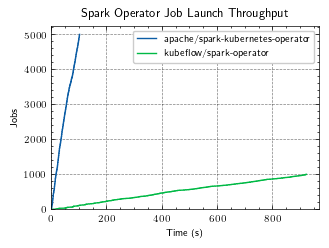

In [6]:
def plot_operators_throughput(apache_path: str, kubeflow_path: str):
    apache_df = pd.read_csv(apache_path)
    kubeflow_df = pd.read_csv(kubeflow_path)

    for df in (apache_df, kubeflow_df):
        t0 = df["start"].min()
        df["start_rel"] = df["start"] - t0
        df["end_rel"] = df["end"] - t0

    def cum_curve(df, time_col):
        ts = np.sort(df[time_col].values)
        counts = np.arange(1, len(ts) + 1)
        ts = np.insert(ts, 0, 0)
        counts = np.insert(counts, 0, 0)
        return ts, counts

    ap_t, ap_c = cum_curve(apache_df, "end_rel")
    kf_t, kf_c = cum_curve(kubeflow_df, "end_rel")

    fig, ax = plt.subplots(figsize=(3.3, 2.5))
    ax.step(ap_t, ap_c, label="apache/spark-kubernetes-operator")
    ax.step(kf_t, kf_c, label="kubeflow/spark-operator")

    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_title("Spark Operator Job Launch Throughput")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Jobs")
    ax.legend()


with save_plot("operator/out/throughput.png"):
    plot_operators_throughput(
        apache_path="operator/src/results_apache.csv",
        kubeflow_path="operator/src/results_kubeflow.csv",
    )

# Scheduler

In [ ]:
from dataclasses import dataclass
from typing import List
import random

# --- Константы бенчмарка ------------------------------------------------------
N_NODES = 8
CPU_PER_NODE = 64
TOTAL_CLUSTER_CPU = N_NODES * CPU_PER_NODE  # 512
WORKLOAD_MULTIPLIER = 20  # 20× объём кластера
TARGET_TOTAL_CPU = TOTAL_CLUSTER_CPU * WORKLOAD_MULTIPLIER  # 10 240
JOB_MAX_CPU = TOTAL_CLUSTER_CPU // 2  # 256
INSTANCE_TYPES = (1, 2, 4, 8, 16, 32, 64)
RUNTIME_MIN, RUNTIME_MAX = 2.0, 10.0  # секунды


# --- Модель задания -----------------------------------------------------------
@dataclass
class Job:
    workers: int  # сколько воркеров
    w_cpu: int  # CPU на воркер
    runtime: float  # сек; одинаково для всех воркеров

    @property
    def total_cpu(self) -> int:
        """Общее CPU-потребление задания (worker-сек не считаем)."""
        return self.workers * self.w_cpu


# --- Генерация профиля --------------------------------------------------------
def generate_workload(seed: int = 42) -> List[Job]:
    """
    Возвращает список Job, суммарный CPU-объём ≈ TARGET_TOTAL_CPU.
    Вызов с одним и тем же seed -> идентичный профиль.
    """
    rng = random.Random(seed)
    jobs: List[Job] = []
    total_cpu = 0

    while total_cpu < TARGET_TOTAL_CPU:
        w_cpu = rng.choice(INSTANCE_TYPES)

        # Не даём job превысить JOB_MAX_CPU.
        max_workers = JOB_MAX_CPU // w_cpu
        workers = rng.randint(1, max_workers)

        runtime = rng.uniform(RUNTIME_MIN, RUNTIME_MAX)

        job = Job(workers=workers, w_cpu=w_cpu, runtime=runtime)
        jobs.append(job)

        total_cpu += job.total_cpu

    rng.shuffle(jobs)  # случайный порядок поступления в очередь
    return jobs


# --- Пример использования -----------------------------------------------------
if __name__ == "__main__":
    jobs = generate_workload()
    print(f"Сгенерировано job: {len(jobs)}")
    print(f"Суммарный CPU объём: {sum(j.total_cpu for j in jobs)}")
    print("Первые 5 записей:", *jobs[:20], sep="\n  ")


In [ ]:
W = 0
for job in jobs:
    W += job.workers * job.w_cpu * job.runtime

print(W)

In [ ]:
W = 59020
print(59020 / (0.91 * 512))  # volcano
print(59020 / (0.87 * 512))  # yunikorn
print(59020 / (0.82 * 512))  # kueue
print(59020 / (0.65 * 512))  # default

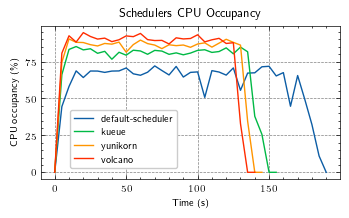

In [7]:
def plot_schedulers_cpu_occupancy():
    STEP_SEC = 5  # шаг дискретизации (с)
    RAMP_UP_RATIO = 0.04  # доля makespan на разгон
    TAIL_RATIO = 0.10  # доля makespan на слив
    TAIL_STEPS = 4  # сколько "ступенек" в хвосте
    NOISE_STD = 2.0  # шум на плато (+/- pp)
    DIP_PROB = 0.03  # вероятность кратковременной "ямы"
    DIP_DEPTH = 0.25  # глубина ямы (доля уровня)

    SCHEDULERS = {
        "default-scheduler": dict(util=68, makespan=191),
        "kueue": dict(util=82, makespan=155),
        "yunikorn": dict(util=87, makespan=146),
        "volcano": dict(util=91, makespan=141),
    }

    # ------------------------- генерация одной кривой ---------------------------
    def make_curve(target_util: float, makespan: int, name: str):
        tail_steps = 2
        dp_probe = DIP_PROB
        dp_depth = DIP_DEPTH
        if name == "default-scheduler":
            tail_steps = 4
            dp_probe = 0.085
            dp_depth = 0.38

        ramp_up_end = makespan * RAMP_UP_RATIO
        tail_begin = makespan * (1 - TAIL_RATIO)
        tail_duration = makespan - tail_begin
        step_len = tail_duration / tail_steps

        t, occ = [], []
        ti = 0.0
        while ti <= makespan:  # идём строго до makespan включительно
            if ti <= ramp_up_end:
                level = target_util * (ti / ramp_up_end)

            elif ti < tail_begin:
                level = target_util + np.random.normal(0, NOISE_STD)
                if np.random.rand() < dp_probe:
                    level *= 1 - np.random.uniform(0, dp_depth)

            else:
                stair = int((ti - tail_begin) // step_len)
                stair_frac = np.random.uniform(0.6, 1) * (1 - (stair + 1) / tail_steps)  # 0.75, 0.50, 0.25, 0
                level = target_util * max(stair_frac, 0)

            t.append(ti)
            occ.append(np.clip(level, 0, 100))
            ti += STEP_SEC

        return np.array(t), np.array(occ)

    np.random.seed(15)  #4
    fig, ax = plt.subplots(figsize=(3.5, 2.2))
    for name, spec in SCHEDULERS.items():
        t, o = make_curve(spec["util"], spec["makespan"], name)
        ax.plot(t, o, label=name)

    ax.set_title("Schedulers CPU Occupancy")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"CPU occupancy (\%)")
    ax.legend(loc="upper left", ncol=1, bbox_to_anchor=(0.08, 0.48))


with save_plot("scheduler/out/cpu_occupancy.png"):
    plot_schedulers_cpu_occupancy()

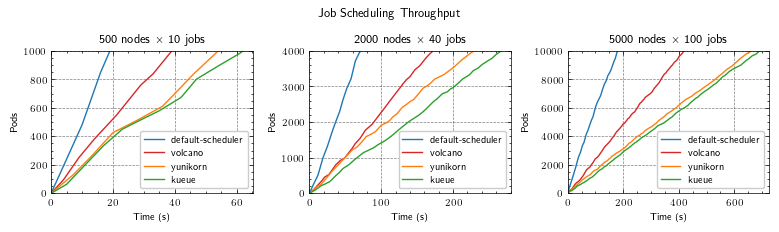

In [8]:
def plot_scheduling_throughput():
    np.random.seed(9)

    SCENARIOS = [
        dict(title="500 nodes × 10 jobs", total_pods=1000,
             sched={"default-scheduler": 19,
                    "volcano": 39,
                    "yunikorn": 54,
                    "kueue": 62}),
        dict(title="2000 nodes × 40 jobs", total_pods=4000,
             sched={"default-scheduler": 71,
                    "volcano": 172,
                    "yunikorn": 229,
                    "kueue": 267}),
        dict(title="5000 nodes × 100 jobs", total_pods=10000,
             sched={"default-scheduler": 179,
                    "volcano": 418,
                    "yunikorn": 662,
                    "kueue": 691}),
    ]

    COLORS = {
        "default-scheduler": "#1f77b4",  # blue
        "volcano": "#d62728",  # red
        "yunikorn": "#ff7f0e",  # orange
        "kueue": "#2ca02c",  # green
    }
    STEP_SEC = 1.0

    def throughput_curve(total, end_time, step=STEP_SEC):
        t = np.arange(0, end_time + step, step)
        pods = np.zeros_like(t)

        base_rate = total / end_time

        cp, cur = [0.], 0.
        while cp[-1] < end_time:
            cp.append(cp[-1] + np.random.uniform(4, 8))
        cp[-1] = end_time

        seg = 0
        factor = np.random.uniform(0.6, 1.4)
        for i in range(1, len(t)):
            if t[i] > cp[seg + 1]:
                seg += 1
                factor = np.random.uniform(0.5, 1.5)
            cur += base_rate * factor * step
            pods[i] = cur

        scale = total / pods[-1]
        pods = pods * scale
        pods[-1] = total

        first_full = np.argmax(pods >= total)
        pods[first_full] = total
        return t[:first_full + 1], pods[:first_full + 1]

    fig, axes = plt.subplots(1, 3, figsize=(7.8, 2.3), sharey=False)

    for ax, sc in zip(axes, SCENARIOS):
        total = sc["total_pods"]
        ax.set_title(sc["title"])
        for name, dur in sc["sched"].items():
            t, p = throughput_curve(total, dur)
            ax.plot(t, p, color=COLORS[name], label=name)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Pods")
        ax.set_xlim(left=0)
        ax.set_ylim(0, total)
        ax.legend(loc="lower right")

    fig.suptitle("Job Scheduling Throughput", y=0.97)


with save_plot("scheduler/out/throughput.png"):
    plot_scheduling_throughput()

# Defaults

In [ ]:
def process_csv(input_path: str, output_path: str):
    df = pd.read_csv(input_path)
    mask = df['query'].str.match(r'^query\d+(_part\d+)?$')
    df_q = df[mask].copy()
    df_q['q_num'] = df_q['query'].str.extract(r'^query(\d+)', expand=False).astype(int)
    df_grouped = (
        df_q
        .groupby('q_num', as_index=False)['time/milliseconds']
        .sum()
        .rename(columns={'time/milliseconds': 'milliseconds'})
    )
    df_grouped['query'] = df_grouped['q_num'].apply(lambda x: f'q{x}')
    df_grouped = df_grouped.sort_values('q_num')[['query', 'milliseconds']]
    df_grouped.to_csv(output_path, index=False)


In [ ]:
process_csv('defaults/src/tpc_h_time_100.csv', 'defaults/tpc_h_100__3_5_5_base.csv')
process_csv('defaults/src/tpc_ds_time_100.csv', 'defaults/tpc_ds_100__3_5_5_base.csv')

In [ ]:
def _make_synthetic_series(base_times: np.ndarray, target_imp: float, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)

    t = base_times.astype(float)
    total = t.sum()

    raw_deltas = np.random.normal(loc=target_imp, scale=target_imp / 2, size=len(t))

    c = (target_imp * total - (t * raw_deltas).sum()) / total

    final_deltas = raw_deltas + c
    times_new = t * (1 - final_deltas)

    times_new = np.clip(times_new, a_min=1.0, a_max=None)

    return np.round(times_new).astype(int)


def generate_synthetic_csv(
        base_csv_path: str,
        output_prefix: str,
        scenarios: dict[str, float],
        seed: int = 42
):
    df_base = pd.read_csv(base_csv_path)
    if set(df_base.columns) != {"query", "milliseconds"}:
        raise ValueError("Входной CSV должен иметь ровно колонки 'query' и 'milliseconds'.")

    base_queries = df_base["query"].values
    base_times = df_base["milliseconds"].values

    for scenario_name, target_imp in scenarios.items():
        if not (0 < target_imp < 1):
            raise ValueError(f"target_imp для '{scenario_name}' должно быть между 0 и 1 (например, 0.06).")

        seed_scn = seed + abs(hash(scenario_name)) % 10_000

        synthetic_times = _make_synthetic_series(base_times, target_imp, seed=seed_scn)

        df_new = pd.DataFrame({
            "query": base_queries,
            "milliseconds": synthetic_times
        })

        out_path = f"{output_prefix}_{scenario_name}.csv"
        df_new.to_csv(out_path, index=False)
        print(f"Сгенерирован: {out_path}  (target_imp={target_imp:.2%}, seed={seed_scn})")


In [ ]:
scenarios = {
    "3_5_5_tuned": 0.08,
    "4_0_0_base": 0.07,
    "4_0_0_tuned": 0.10
}

generate_synthetic_csv(
    base_csv_path="defaults/tpc_ds_100__3_5_5_base.csv",
    output_prefix="defaults/tpc_ds_100__",
    scenarios=scenarios,
    seed=0,
)

generate_synthetic_csv(
    base_csv_path="defaults/tpc_h_100__3_5_5_base.csv",
    output_prefix="defaults/tpc_h_100__",
    scenarios=scenarios,
    seed=1,
)

In [94]:
def plot_total_times(scenario_paths: dict[str, str], title: str):
    totals = []
    for label, path in scenario_paths.items():
        df = pd.read_csv(path)
        total_ms = df["milliseconds"].sum()
        totals.append((label, total_ms / 1000))

    totals_sorted = sorted(totals, key=lambda x: x[1], reverse=True)
    labels, times_s = zip(*totals_sorted)

    plt.figure(figsize=(3.3, 2.5))
    bars = plt.bar(labels, times_s)
    plt.ylabel("Total execution time (s)")
    plt.xlabel("Spark")
    plt.xticks(rotation=0)
    plt.tick_params(axis="x", which="both", top=False, bottom=False)
    plt.ylim(0, max(times_s) * 1.1)
    plt.grid(axis="x")
    plt.title(title)

    for bar, val in zip(bars, times_s):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{val:.1f}", ha="center", va="bottom")


def plot_per_query(
        scenario_paths: dict[str, str],
        title: str,
        figsize: tuple[float, float] = (4, 2.5),
        margins_x: float = None,
        q_subset: list[int] | range | None = None,
):
    dfs = {label: pd.read_csv(path).set_index("query")["milliseconds"]
           for label, path in scenario_paths.items()}
    df_all = pd.DataFrame(dfs)

    df_all["q_num"] = df_all.index.to_series().str.extract(r"q(\d+)", expand=False).astype(int)
    df_all = df_all.sort_values("q_num")

    if q_subset is not None:
        mask = df_all["q_num"].isin(set(q_subset))
        df_all = df_all[mask]

    df_all = df_all.drop(columns=["q_num"])
    queries = df_all.index.tolist()
    n_queries = len(queries)
    n_scenarios = len(scenario_paths)
    labels = list(scenario_paths.keys())

    x = np.arange(n_queries)
    width = 0.8 / n_scenarios

    plt.figure(figsize=figsize)
    for i, lbl in enumerate(labels):
        plt.bar(x + i * width, df_all[lbl].values / 1000, width=width, label=lbl)

    if margins_x:
        plt.margins(x=margins_x)

    plt.xlabel("Query")
    plt.ylabel("Execution time (s)")
    plt.title(title)
    plt.xticks(x + width * (n_scenarios - 1) / 2, queries, rotation=45)
    plt.grid(axis="x")
    plt.tick_params(axis="x", which="both", top=False, bottom=False)
    plt.legend()


def plot_speedup(
        base_path: str,
        comp_path: str,
        title: str,
        figsize: tuple[float, float] = (4.4, 2.5),
        margins_x: float = None,
        text_rotation: int = 0,
        text_fontsize: int = 4,
        q_subset: list[int] | range | None = None,
):
    df_base = pd.read_csv(base_path).set_index("query")["milliseconds"]
    df_comp = pd.read_csv(comp_path).set_index("query")["milliseconds"]

    data = []
    for q, t_base in df_base.items():
        t_comp = df_comp.get(q, None)
        if t_comp is None or t_comp <= 0:
            continue
        speedup = t_base / t_comp
        data.append((q, speedup))

    if not data:
        raise RuntimeError("Нет общих запросов или время неправильно задано.")

    df_sp = pd.DataFrame(data, columns=["query", "speedup"])
    df_sp = df_sp.sort_values("speedup", ascending=False).reset_index(drop=True)

    if q_subset is not None:
        idx_list = list(q_subset)
        idx_list = [i for i in idx_list if 0 <= i < len(df_sp)]
        df_sp = df_sp.iloc[idx_list].reset_index(drop=True)

    df_sp["height"] = df_sp["speedup"] - 1.0

    labels = df_sp["query"].tolist()
    x = np.arange(len(labels))

    plt.figure(figsize=figsize)

    colors = np.where(df_sp["height"] >= 0, "#1f77b4", "#d62728")
    bars = plt.bar(x, df_sp["height"], bottom=1.0, color=colors)

    all_sp = df_sp["speedup"].values
    y_range = all_sp.max() - all_sp.min()
    offset = y_range * 0.008 if y_range > 0 else 0.008

    text_positions = []
    for bar, sp in zip(bars, df_sp["speedup"]):
        if sp >= 1.0:
            y_text = sp + offset
            va = "bottom"
        else:
            y_text = sp - offset
            va = "top"
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            y_text, f"{sp:.2f}",
            ha="center",
            va=va,
            fontsize=text_fontsize,
            rotation=text_rotation,
        )
        text_positions.append((y_text, va))

    if margins_x:
        plt.margins(x=margins_x)

    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Query")
    plt.ylabel("Speedup ×")
    plt.tick_params(axis="x", which="both", top=False, bottom=False)
    plt.grid(axis="x")
    plt.title(title)

    y_text_values = [y for (y, _) in text_positions]
    y_text_min = min(y_text_values)
    y_text_max = max(y_text_values)
    plt.ylim(min(y_text_min - abs(y_range) * 0.1, 1.0 - offset), y_text_max + abs(y_range) * 0.1)

    plt.axhline(1.0, color="gray", linewidth=0.8)


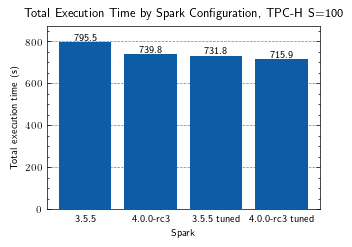

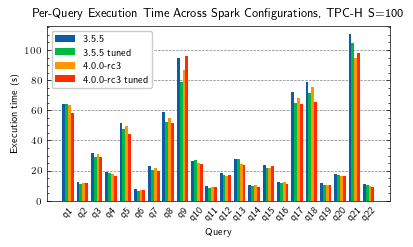

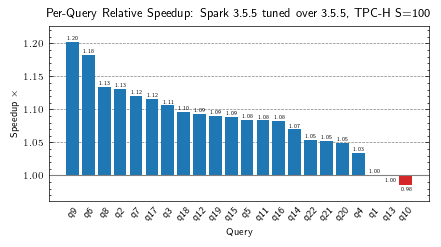

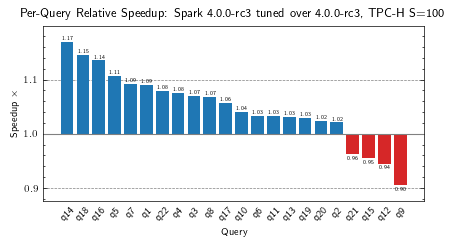

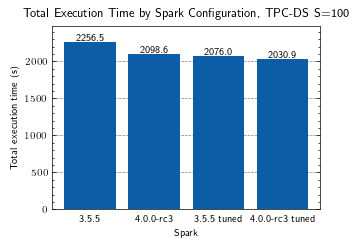

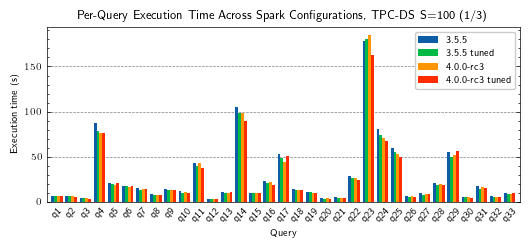

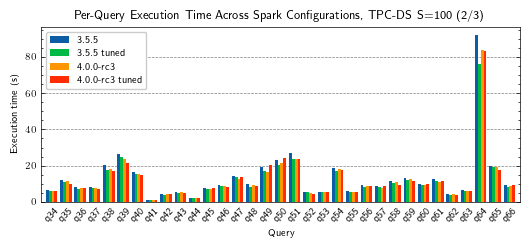

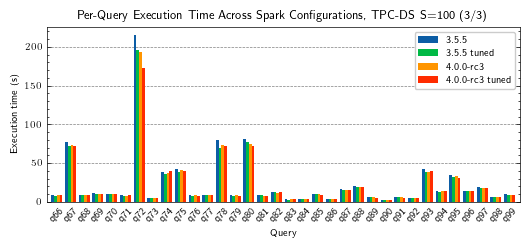

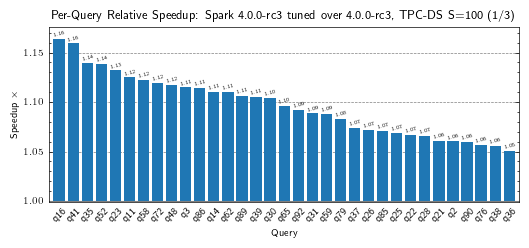

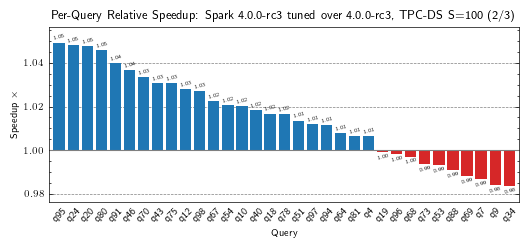

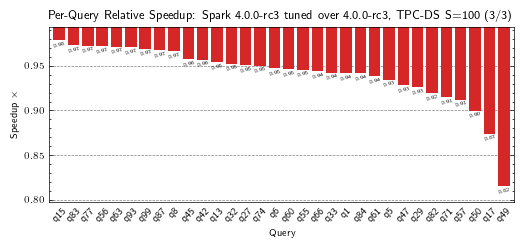

In [95]:
scenarios = {
    "3.5.5": "defaults/tpc_h_100__3_5_5_base.csv",
    "3.5.5 tuned": "defaults/tpc_h_100___3_5_5_tuned.csv",
    "4.0.0-rc3": "defaults/tpc_h_100___4_0_0_base.csv",
    "4.0.0-rc3 tuned": "defaults/tpc_h_100___4_0_0_tuned.csv"
}

with save_plot("defaults/out/tpc_h_100__total_time_comparison.png"):
    plot_total_times(
        scenarios,
        title="Total Execution Time by Spark Configuration, TPC-H S=100",
    )

with save_plot("defaults/out/tpc_h_100__per_query_comparison.png"):
    plot_per_query(
        scenarios,
        title="Per-Query Execution Time Across Spark Configurations, TPC-H S=100",
    )

with save_plot("defaults/out/tpc_h_100__speedup__3_5_5_tuned_vs_3_5_5_base.png"):
    plot_speedup(
        base_path="defaults/tpc_h_100__3_5_5_base.csv",
        comp_path="defaults/tpc_h_100___3_5_5_tuned.csv",
        title="Per-Query Relative Speedup: Spark 3.5.5 tuned over 3.5.5, TPC-H S=100",
    )

with save_plot("defaults/out/tpc_h_100__speedup__4_0_0_tuned_vs_4_0_0_base.png"):
    plot_speedup(
        base_path="defaults/tpc_h_100___4_0_0_base.csv",
        comp_path="defaults/tpc_h_100___4_0_0_tuned.csv",
        title="Per-Query Relative Speedup: Spark 4.0.0-rc3 tuned over 4.0.0-rc3, TPC-H S=100",
    )

scenarios = {
    "3.5.5": "defaults/tpc_ds_100__3_5_5_base.csv",
    "3.5.5 tuned": "defaults/tpc_ds_100___3_5_5_tuned.csv",
    "4.0.0-rc3": "defaults/tpc_ds_100___4_0_0_base.csv",
    "4.0.0-rc3 tuned": "defaults/tpc_ds_100___4_0_0_tuned.csv"
}

with save_plot("defaults/out/tpc_ds_100__total_time_comparison.png"):
    plot_total_times(
        scenarios,
        title="Total Execution Time by Spark Configuration, TPC-DS S=100",
    )

with save_plot("defaults/out/tpc_ds_100__per_query_comparison__1.png"):
    plot_per_query(
        scenarios,
        title="Per-Query Execution Time Across Spark Configurations, TPC-DS S=100 (1/3)",
        figsize=(5.3, 2.5),
        margins_x=0.01,
        q_subset=range(1, 34),
    )

with save_plot("defaults/out/tpc_ds_100__per_query_comparison__2.png"):
    plot_per_query(
        scenarios,
        title="Per-Query Execution Time Across Spark Configurations, TPC-DS S=100 (2/3)",
        figsize=(5.3, 2.5),
        margins_x=0.01,
        q_subset=range(34, 67),
    )

with save_plot("defaults/out/tpc_ds_100__per_query_comparison__3.png"):
    plot_per_query(
        scenarios,
        title="Per-Query Execution Time Across Spark Configurations, TPC-DS S=100 (3/3)",
        figsize=(5.3, 2.5),
        margins_x=0.01,
        q_subset=range(66, 100),
    )

with save_plot("defaults/out/tpc_ds_100__speedup__4_0_0_tuned_vs_4_0_0_base__1.png"):
    plot_speedup(
        base_path="defaults/tpc_ds_100___4_0_0_base.csv",
        comp_path="defaults/tpc_ds_100___4_0_0_tuned.csv",
        title="Per-Query Relative Speedup: Spark 4.0.0-rc3 tuned over 4.0.0-rc3, TPC-DS S=100 (1/3)",
        figsize=(5.3, 2.5),
        margins_x=0.01,
        text_rotation=15,
        q_subset=range(1, 34),
    )

with save_plot("defaults/out/tpc_ds_100__speedup__4_0_0_tuned_vs_4_0_0_base__2.png"):
    plot_speedup(
        base_path="defaults/tpc_ds_100___4_0_0_base.csv",
        comp_path="defaults/tpc_ds_100___4_0_0_tuned.csv",
        title="Per-Query Relative Speedup: Spark 4.0.0-rc3 tuned over 4.0.0-rc3, TPC-DS S=100 (2/3)",
        figsize=(5.3, 2.5),
        margins_x=0.01,
        text_rotation=15,
        q_subset=range(34, 67),
    )

with save_plot("defaults/out/tpc_ds_100__speedup__4_0_0_tuned_vs_4_0_0_base__3.png"):
    plot_speedup(
        base_path="defaults/tpc_ds_100___4_0_0_base.csv",
        comp_path="defaults/tpc_ds_100___4_0_0_tuned.csv",
        title="Per-Query Relative Speedup: Spark 4.0.0-rc3 tuned over 4.0.0-rc3, TPC-DS S=100 (3/3)",
        figsize=(5.3, 2.5),
        margins_x=0.01,
        text_rotation=15,
        q_subset=range(67, 100),
    )

In [161]:
print(1)

1


# Persistent

# RSS

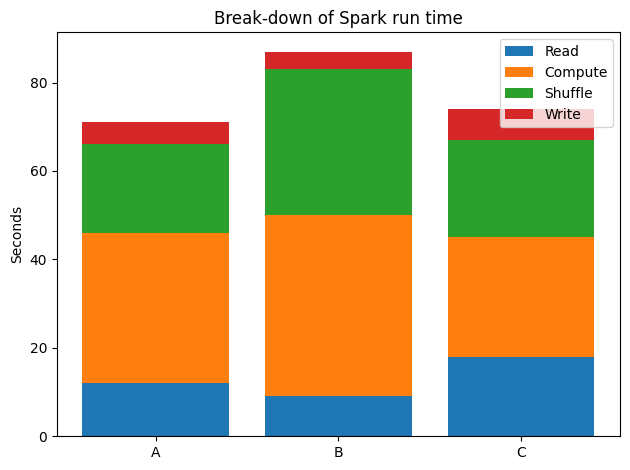

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# df: run, read, compute, shuffle, write  (в секундах)
df = pd.DataFrame({
    "run":    ["A", "B", "C"],
    "read":   [12, 9, 18],
    "compute":[34, 41, 27],
    "shuffle":[20, 33, 22],
    "write":  [5, 4, 7]
})

# stacked bar
bottom = None
for col in ["read", "compute", "shuffle", "write"]:
    plt.bar(df["run"], df[col], bottom=bottom, label=col.capitalize())
    bottom = (df[col] if bottom is None else bottom + df[col])

plt.ylabel("Seconds")
plt.title("Break-down of Spark run time")
plt.legend()
plt.tight_layout()
plt.show()


# Benchmarks

## Operators

In [ ]:
apache_df = pd.read_csv("../../benckmarks/operator/benchmark/results_apache.csv")
kubeflow_df = pd.read_csv("../../benckmarks/operator/benchmark/results_kubeflow.csv")

for df in (apache_df, kubeflow_df):
    t0 = df["start"].min()
    df["start_rel"] = df["start"] - t0
    df["end_rel"] = df["end"] - t0
    df["latency"] = df["end_rel"] - df["start_rel"]

In [ ]:
def cum_curve(df, time_col):
    ts = np.sort(df[time_col].values)
    counts = np.arange(1, len(ts) + 1)
    ts = np.insert(ts, 0, 0)
    counts = np.insert(counts, 0, 0)
    return ts, counts


ap_t, ap_c = cum_curve(apache_df, "end_rel")
kf_t, kf_c = cum_curve(kubeflow_df, "end_rel")
fig, ax = plt.subplots(figsize=(8, 5))
ax.step(ap_t, ap_c, where="post", label="apache/spark-kubernetes-operator")
ax.step(kf_t, kf_c, where="post", label="kubeflow/spark-operator")
ax.set_title("Jobs Throughput")
ax.set_xlabel("time (s)")
ax.set_ylabel("jobs")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
print("apache/spark-kubernetes-operator:", apache_df["latency"].quantile(0.9))
print("kubeflow/spark-operator:", kubeflow_df["latency"].quantile(0.9))

## Операторы

In [ ]:
df_apache = pd.read_csv("../operator/throughput-result-apache.yaml.tmpl-20250425-013615.csv")
df_kubeflow = pd.read_csv("../operator/throughput-result-kubeflow.yaml.tmpl-20250425-010903.csv")

fig, ax = plt.subplots()
ax.plot(df_apache["secs"], df_apache["pods"], label="apache/spark-kubernetes-operator")
ax.plot(df_kubeflow["secs"], df_kubeflow["pods"], label="kubeflow/spark-operator")
ax.legend(fontsize=14)
ax.set(xlabel="time (s)", ylabel="jobs", title="Operators Throughput")
ax.autoscale(tight=True)
fig.savefig("../operator/throughput.png", dpi=300)
plt.show()
plt.close()

## Планировщики

500, 2000, 5000 узлов x 50 подов, 2 пода/нода

2000 nodes x 10, 100, 1000, 2000 pods

2000 nodes x 50 pod (2пода/нода) x 3 tolerations, 6 node-affinity, 3 priority-class

In [ ]:
# 500, 2000, 5000 узлов x 50 подов, 2 пода/нода
# 500: 1'000 подов всего
# 2000: 4'000 подов всего
# 5000: 10'000 подов всего
# default-scheduler работает быстро (2000 узлов примерно за 80 секунд)
# default-scheduler (с плагинами) самый медленный, работает в 10-15 раз медленее
# volcano (с плагинами) работает на 10% быстрее default-scheduler
# yunikorn работает на 20% быстрее default-scheduler
# при увеличении кол-ва узлов с 500 до 2000 производительность всех планировщиков кроме default-scheduler (с плагинами) падает на 15%, а default-scheduler (с плагинами) на 30%
# при увеличении кол-ва узлов с 2000 до 5000 производительность всех планировщиков кроме default-scheduler (с плагинами) падает на 5%, а default-scheduler (с плагинами) на 20%

# default-scheduler
# 1'000 / 33 = 32/с
# 4'000 / 160 = 28/с
# 10'000 / 385 = 26/c
# default-scheduler (с плагинами)
# 1'000 / 149 = 6.7/с
# 4'000 / 910 = 4.4/с
# 10'000 / 3333 = 2.4/c
# volcano
# 1'000 / 27 = 37/c
# 4'000 / 129 = 31/c
# 10'000 / 345 = 29/c
# yunikorn
# 1'000 / 28 = 36/c
# 4'000 / 121 = 33/c
# 10'000 / 312 = 32/c

# -4, -12, -4, -4
# -10, -42, -10, -10
# -25, -150, -25, -25
df_default_scheduler_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 29, 30), np.zeros(1001 - 30))),
    "pods": np.linspace(0, 1000, 1001),
})
df_plugins_scheduler_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 137, 138), np.zeros(1001 - 138))),
    "pods": np.linspace(0, 1000, 1001),
})
df_volcano_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 23, 24), np.zeros(1001 - 24))),
    "pods": np.linspace(0, 1000, 1001),
})
df_yunikorn_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 24, 27), np.zeros(1001 - 27))),
    "pods": np.linspace(0, 1000, 1001),
})
#
df_default_scheduler_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 150, 151), np.zeros(4001 - 151))),
    "pods": np.linspace(0, 4000, 4001),
})
df_plugins_scheduler_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 868, 869), np.zeros(4001 - 869))),
    "pods": np.linspace(0, 4000, 4001),
})
df_volcano_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 119, 120), np.zeros(4001 - 120))),
    "pods": np.linspace(0, 4000, 4001),
})
df_yunikorn_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 111, 112), np.zeros(4001 - 112))),
    "pods": np.linspace(0, 4000, 4001),
})
#
df_default_scheduler_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 360, 361), np.zeros(10001 - 361))),
    "pods": np.linspace(0, 10000, 10001),
})
df_plugins_scheduler_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 3183, 3184), np.zeros(10001 - 3184))),
    "pods": np.linspace(0, 10000, 10001),
})
df_volcano_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 320, 321), np.zeros(10001 - 321))),
    "pods": np.linspace(0, 10000, 10001),
})
df_yunikorn_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 287, 288), np.zeros(10001 - 288))),
    "pods": np.linspace(0, 10000, 10001),
})

In [ ]:
def stretch_secs_to_pods(
        secs: np.ndarray,
        pods: np.ndarray,
        mode: str = 'floor'
) -> np.ndarray:
    """
    Растягивает (upsample) массив secs до длины массива pods.

    Алгоритм:
    1. Отбрасываем trailing-нули (те самые 0 после окончания планирования).
    2. Пусть N = len(nonzero_secs), M = len(pods).
    3. Строим линейный вектор позиций pos = linspace(0, N-1, M).
    4. В зависимости от mode превращаем pos в целочисленные индексы:
       - 'floor': floor(pos)
       - 'ceil' : ceil(pos)
       - 'round': round(pos)
    5. Берём new_secs = nonzero_secs[indices].

    Возвращает new_secs длины M.
    """
    # 1) отбросить trailing-нули
    nz = secs[secs > 0]
    if nz.size == 0:
        raise ValueError("в secs нет положительных значений")

    N = nz.size
    M = pods.size

    # 2) позиции
    pos = np.linspace(0, N - 1, M)

    # 3) индексы
    if mode == 'floor':
        idx = np.floor(pos).astype(int)
    elif mode == 'ceil':
        idx = np.ceil(pos).astype(int)
    elif mode == 'round':
        idx = np.round(pos).astype(int)
    else:
        raise ValueError("mode must be one of 'floor','ceil','round'")

    # на всякий случай зажимаем индексы в [0, N-1]
    idx = np.clip(idx, 0, N - 1)

    # 4) финальный вектор
    return nz[idx]


def add_small_noise_to_pods(pods: np.ndarray, sigma: float = 0.3) -> np.ndarray:
    noisy = pods + np.random.normal(loc=0.0, scale=sigma, size=pods.shape)
    noisy = np.maximum.accumulate(noisy)
    return np.round(noisy).astype(int).clip(0)


all_dfs = {
    500: {
        'default': df_default_scheduler_500,
        'plugins': df_plugins_scheduler_500,
        'volcano': df_volcano_500,
        'yunikorn': df_yunikorn_500,
    },
    2000: {
        'default': df_default_scheduler_2000,
        'plugins': df_plugins_scheduler_2000,
        'volcano': df_volcano_2000,
        'yunikorn': df_yunikorn_2000,
    },
    5000: {
        'default': df_default_scheduler_5000,
        'plugins': df_plugins_scheduler_5000,
        'volcano': df_volcano_5000,
        'yunikorn': df_yunikorn_5000,
    },
}

for size, dfs in all_dfs.items():
    for name, df in dfs.items():
        df['secs'] = stretch_secs_to_pods(df['secs'].values, df['pods'].values)
    # if size == 500:
    for _ in range(5):
        for name, df in dfs.items():
            df['pods'] = add_small_noise_to_pods(df['pods'].values, sigma=0.6)

In [ ]:
cases = [500, 2000, 5000]
dfs_default = [all_dfs[500]["default"], all_dfs[2000]["default"], all_dfs[5000]["default"]]
dfs_plugins = [all_dfs[500]["plugins"], all_dfs[2000]["plugins"], all_dfs[5000]["plugins"]]
dfs_volcano = [all_dfs[500]["volcano"], all_dfs[2000]["volcano"], all_dfs[5000]["volcano"]]
dfs_yunikorn = [all_dfs[500]["yunikorn"], all_dfs[2000]["yunikorn"], all_dfs[5000]["yunikorn"]]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, case, df0, df1, df2, df3 in zip(axes, cases, dfs_default, dfs_plugins, dfs_volcano, dfs_yunikorn):
    ax.plot(df0["secs"], df0["pods"], label="default-scheduler")
    ax.plot(df1["secs"], df1["pods"], label="default-scheduler (plugins)")
    ax.plot(df2["secs"], df2["pods"], label="volcano")
    ax.plot(df3["secs"], df3["pods"], label="yunikorn")

    ax.set_xlabel("time (s)")
    ax.autoscale(tight=True)

    ax.legend(
        fontsize=12,
        title=f"{case} nodes × {int(case / 50)} jobs",
        title_fontsize=14,
    )

axes[0].set_ylabel("pods")

fig.tight_layout()
fig.savefig("../scheduler/batch_nodes.png", dpi=300)
plt.show()
plt.close()

In [ ]:
df_default_scheduler_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 150, 151), np.zeros(4001 - 151))),
    "pods": np.linspace(0, 4000, 4001),
})
df_plugins_scheduler_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 921, 922), np.zeros(4001 - 922))),
    "pods": np.linspace(0, 4000, 4001),
})
df_volcano_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 220, 221), np.zeros(4001 - 221))),
    "pods": np.linspace(0, 4000, 4001),
})
df_yunikorn_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 210, 211), np.zeros(4001 - 211))),
    "pods": np.linspace(0, 4000, 4001),
})

In [ ]:
all_dfs_affinity = {
    2000: {
        'default': df_default_scheduler_affinity_2000,
        'plugins': df_plugins_scheduler_affinity_2000,
        'volcano': df_volcano_affinity_2000,
        'yunikorn': df_yunikorn_affinity_2000,
    },
}

for size, dfs in all_dfs_affinity.items():
    for name, df in dfs.items():
        df['secs'] = stretch_secs_to_pods(df['secs'].values, df['pods'].values)
    # if size == 500:
    for _ in range(5):
        for name, df in dfs.items():
            df['pods'] = add_small_noise_to_pods(df['pods'].values, sigma=0.6)

In [ ]:
fig, ax = plt.subplots()
ax.plot(df_default_scheduler_affinity_2000["secs"], df_default_scheduler_affinity_2000["pods"],
        label="default-scheduler")
ax.plot(df_plugins_scheduler_affinity_2000["secs"], df_plugins_scheduler_affinity_2000["pods"],
        label="default-scheduler (plugins)")
ax.plot(df_volcano_affinity_2000["secs"], df_volcano_affinity_2000["pods"], label="volcano")
ax.plot(df_yunikorn_affinity_2000["secs"], df_yunikorn_affinity_2000["pods"], label="yunikorn")
ax.legend(fontsize=14)
ax.set(xlabel="time (s)", ylabel="pods", title=f"Batch Scheduling (Predicates)")
ax.autoscale(tight=True)
fig.savefig("../scheduler/batch_affinity.png", dpi=300)
plt.show()
plt.close()

In [ ]:
# 1) создаём временную ось: 10 минут с шагом 10 секунд
times = pd.date_range(start="2025-04-25 00:00:00", periods=61, freq="10s")

# 2) целевые средние уровни occupancy (в процентах)
targets = {
    "default-scheduler": 69,
    "default-scheduler (plugins)": 87,
    "volcano": 94,
    "yunikorn": 96,
}


# 3) функция генерации кривой occupancy
def simulate_occupancy(times, target, tau=30, noise_level=2, dip_chance=0.02):
    t = (times - times[0]).total_seconds().values
    # экспоненциальный рост к target
    base = target * (1 - np.exp(-t / tau))
    # добавляем небольшой шум
    noise = np.random.normal(scale=noise_level, size=base.shape)
    occ = base + noise
    # случайные провалы
    dips = np.random.rand(len(occ)) < dip_chance
    occ[dips] *= np.random.uniform(0.5, 0.8, size=dips.sum())
    # ограничиваем 0–100%
    return np.clip(occ, 0, 100)


# 4) собираем DataFrame'ы
dfs = {}
for name, tgt in targets.items():
    dip_chance = 0.015
    if name == "default-scheduler":
        dip_chance = 0.06
    occ = simulate_occupancy(times, tgt, dip_chance=dip_chance, noise_level=2.2)
    dfs[name] = pd.DataFrame({"time": (times - times[0]).total_seconds().values, "occupancy": occ})

# 5) строим все кривые на одном графике
fig, ax = plt.subplots(figsize=(10, 4))
for name, df in dfs.items():
    ax.plot(df["time"], df["occupancy"], label=name)

ax.set_xlabel("time (s)")
ax.set_ylabel("CPU occupancy (%)")
ax.set_title("CPU Occupancy for Schedulers")
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig("../scheduler/cpu_occupancy.png", dpi=300)
plt.show()

## Dynamic Resource Allocation

In [ ]:
# 8 x 2CPU, 8Gi
# job-without-dra
# job-with-dra
# job-with-resource-profile
# профиль нагрузки (на примере job-without-dra)
# TODO

In [ ]:

import pandas as pd

# --- параметры моделирования ---
# длительность в секундах
total_duration = 40 * 60  # 40 минут
dra_gain = 6 * 60  # job-with-dra быстрее на 6 минут
rp_gain = 14 * 60  # job-with-resource-profiles быстрее на 14 минут

# время завершения каждого сценария
end_times = {
    "job-without-dra": total_duration,
    "job-with-dra": total_duration - dra_gain,
    "job-with-resource-profiles": total_duration - rp_gain,
}

# целевые средние уровни CPU (%) для каждого сценария
targets = {
    "job-without-dra": 42,
    "job-with-dra": 60,
    "job-with-resource-profiles": 74,
}

# корректировки: (start_frac, end_frac, multiplier)
#  start_frac, end_frac — доли от выполнения [0…1]
#  multiplier — на сколько домножить CPU (1.15 = +15%, 0.90 = –10%)
adjustments = {
    "job-without-dra": [
        (0.40, 0.55, 1.15),
        (0.70, 0.80, 0.90),
    ],
    "job-with-dra": [
        (0.35, 0.40, 0.5),
        (0.40, 0.55, 1.15),
        (0.70, 0.74, 0.5),
        (0.80, 0.90, 0.95),
    ],
    "job-with-resource-profiles": [
        (0.32, 0.35, 0.5),
        (0.38, 0.55, 1.15),
        (0.64, 0.67, 0.5),
        (0.72, 0.80, 1.10),
        (0.81, 0.84, 0.65),
        (0.85, 0.91, 0.99),
    ],
}

# временная ось: отметки каждые 10 секунд
times = pd.date_range("2025-04-25 10:00:00",
                      periods=total_duration // 120 + 1,
                      freq="120s")


def simulate_cpu_with_adjustments(name, times, target, end_time, adjustments,
                                  tau=60, noise=2):
    """
    Экспоненциальный рост к target%, затем 0 после end_time,
    плюс возможные локальные корректировки по списку adjustments.
    """
    t = (times - times[0]).total_seconds().values
    # 1) базовый экспоненциальный подъём
    base = target * (1 - np.exp(-t / tau))
    # 2) шум
    base += np.random.normal(scale=noise, size=base.shape)
    # 3) обрезаем по концу задачи
    base = np.where(t <= end_time, base, 0.0)

    # 4) применяем локальные корректировки
    #    вычислим долю выполнения для каждой точки
    frac = t / end_time
    for start_frac, end_frac, mult in adjustments[name]:
        mask = (frac >= start_frac) & (frac <= end_frac)
        base[mask] *= mult

    # 5) финальный клиппинг
    return np.clip(base, 0, 100)


# --- собираем все ряды в DataFrame ---
df = pd.DataFrame({"time": times})

for name, tgt in targets.items():
    df[name] = simulate_cpu_with_adjustments(
        name,
        times,
        target=tgt,
        end_time=end_times[name],
        adjustments=adjustments,
        tau=60,
        noise=2
    )

# сохраняем в CSV
csv_path = "cpu_usage_simulated_with_adjustments.csv"
df.to_csv(csv_path, index=False)

for col in df.columns[1:]:
    print("===", col)
    print(df[col].astype(str).str.cat(sep=","))

In [ ]:
def generate_query_performance(queries, solutions, manual_values=None):
    """
    Build a DataFrame of execution times for given queries and solutions.

    Parameters:
    - queries: list of query names (e.g. ["q1","q2",...])
    - solutions: dict mapping solution name to either
         * a scalar or list/array of same length as queries (will be used to generate random around)
         * a callable f(query) -> value
    - manual_values: optional dict of form {solution: {query: value, ...}, ...}
      these override any generated values.

    Returns:
    - DataFrame with index=queries, columns=solutions
    """
    df = pd.DataFrame(index=queries)
    for sol, spec in solutions.items():
        # base generation
        if callable(spec):
            df[sol] = [spec(q) for q in queries]
        else:
            arr = np.array(spec)
            if arr.ndim == 0:
                mean = float(arr)
                df[sol] = mean + np.random.normal(scale=mean * 0.1, size=len(queries))
            elif arr.ndim == 1 and len(arr) == len(queries):
                df[sol] = arr
            else:
                raise ValueError(f"Solution '{sol}' spec must be scalar or 1D array of length {len(queries)}")
        # override by manual_values if provided
        if manual_values and sol in manual_values:
            for q, v in manual_values[sol].items():
                if q in df.index:
                    df.at[q, sol] = v
    return df


def plot_comparison(df, benchmark_name="Benchmark", title=None):
    """
    Plot a grouped bar chart of the DataFrame df (queries x solutions).
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    queries = df.index.tolist()
    sols = df.columns.tolist()
    n = len(queries)
    m = len(sols)
    x = np.arange(n)
    width = 0.8 / m
    for i, sol in enumerate(sols):
        ax.bar(x + i * width, df[sol], width, label=sol)
    ax.set_xticks(x + width * (m - 1) / 2)
    ax.set_xticklabels(queries, rotation=45, ha='right')
    ax.set_ylabel("Query time (sec)")
    ax.set_title(title or f"{benchmark_name} Query Times")
    ax.legend()
    fig.tight_layout()
    plt.show()


# Example usage:

# choose subset of queries
queries = [f"q{str(i).zfill(2)}" for i in range(1, 22)]

# define solutions with a base scalar time (will add noise)
solutions = {
    "Spark3.5": 50,  # base mean 50s
    "Blaze": 30,  # base mean 30s
    "DuckDB": 20  # base mean 20s
}

# override a few manual values
manual = {
    "Spark3.5": {"q05": 100, "q17": 140},
    "Blaze": {"q05": 50, "q17": 80}
}

df_perf = generate_query_performance(queries, solutions, manual_values=manual)
print(df_perf.head())

# plot
plot_comparison(df_perf, benchmark_name="TPC-H 1TB")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def generate_stacked_data(index, components, seed=None):
    """
    Generate random positive data for each component, then normalize rows to sum to 100.

    Parameters:
    - index: list-like of x-axis labels (e.g. dates)
    - components: list of component names
    - seed: optional random seed for reproducibility

    Returns:
    - DataFrame with shape (len(index), len(components)), rows sum to 100
    """
    if seed is not None:
        np.random.seed(seed)
    # random positive values
    data = np.random.rand(len(index), len(components))
    # normalize rows to sum to 100
    data = data / data.sum(axis=1, keepdims=True) * 100
    df = pd.DataFrame(data, index=index, columns=components)
    return df


def plot_stacked_bar(df, xlabel=None, ylabel="Proportion", title=None):
    """
    Plot a stacked bar chart of the DataFrame df (index x components).
    Y-axis is shown in percent.
    """
    components = df.columns.tolist()
    x = np.arange(len(df))
    bottom = np.zeros(len(df))
    fig, ax = plt.subplots(figsize=(10, 5))
    for comp in components:
        ax.bar(x, df[comp], bottom=bottom, label=comp)
        bottom += df[comp].values
    # percent formatter
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}%"))
    ax.set_ylim(0, 100)
    # x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45, ha='right')
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.legend(loc='upper right')
    fig.tight_layout()
    plt.show()


# Example usage
dates = pd.date_range("2022-01-01", periods=10, freq="D").strftime("%Y-%m-%d")
components = ["Data Scan Time", "Shuffle Block Time", "Real Compute Time"]
df = generate_stacked_data(dates, components, seed=42)
plot_stacked_bar(df, xlabel="Date", title="Task Time Breakdown")

In [ ]:
# допустим, у вас 4 этапа:
comps = ["Data Scan Time", "Shuffle Block Time", "Real Compute Time"]
# и произвольные 7 точек по времени
idx = ["t1", "t2", "t3", "t4", "t5", "t6", "t7"]
df = generate_stacked_data(idx, comps, seed=0)
plot_stacked_bar(df, xlabel="Step", title="My Profile")